In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import time
import os
import copy


plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '/Users/dl/Documents/RIT related/Oxford Pet/data'


train_folder ='Petdata\\train'
test_folder='Petdata\\test'

Train_dl= datasets.ImageFolder(train_folder, data_transforms['train'])
Test_dl=   datasets.ImageFolder(test_folder, data_transforms['test'])                                      

image_datasets ={'train':Train_dl,'test': Test_dl}



dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x25a0fe1be50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x25a15c52df0>}

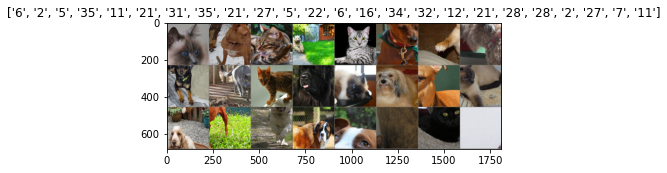

torch.Size([24, 3, 224, 224])

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

inputs.shape

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    testAcc=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase=='test':
                testAcc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,testAcc

In [23]:

#model = models.vgg16(pretrained=True)
# Freeze model weights
#for param in model.parameters():
   # param.requires_grad = False
    
#inputs=4096
#n_classes=37 
#model.classifier[6] = nn.Sequential(
                      #nn.Linear(inputs, 37), 
                      #nn.ReLU(), 
                      #nn.Dropout(0.4),
                      #nn.Linear(256, n_classes),                   
                      #nn.LogSoftmax(dim=1))

# Only training classifier[6]  
#model.classifier

In [24]:
#model=model.to(device)

In [47]:
#ConvNet as fixed feature extractor
#revise model 

#model_conv = torchvision.models.resnet18(pretrained=True)
model_conv = torchvision.models.resnet152(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 37)

model_conv.fc=nn.Sequential(
                      nn.Linear(num_ftrs, 37), 
                      #nn.ReLU(), 
                      #nn.Dropout(0.4),
                      #nn.Linear(256, 37),                   
                      nn.LogSoftmax(dim=1))




model_conv = model_conv.to(device)

print(model_conv)





ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
# Find total parameters and trainable parameters

total_params = sum(p.numel() for p in model_conv.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_conv.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

#135,335,076 total parameters.
#1,074,532 training parameters.



58,219,621 total parameters.
75,813 training parameters.


In [68]:
criterion = nn.CrossEntropyLoss()

#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#optimizer_conv = optim.SGD(model_conv.parameters(),lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.parameters(),lr=1e-5)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [69]:
#train and evaluate 

model_conv , testAcc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.2846 Acc: 0.9113
test Loss: 0.2980 Acc: 0.9171

Epoch 1/19
----------
train Loss: 0.2752 Acc: 0.9168
test Loss: 0.2928 Acc: 0.9158

Epoch 2/19
----------
train Loss: 0.2894 Acc: 0.9079
test Loss: 0.3059 Acc: 0.9103

Epoch 3/19
----------
train Loss: 0.2918 Acc: 0.9123
test Loss: 0.2925 Acc: 0.9145

Epoch 4/19
----------
train Loss: 0.2837 Acc: 0.9123
test Loss: 0.2892 Acc: 0.9166

Epoch 5/19
----------
train Loss: 0.2838 Acc: 0.9141
test Loss: 0.2945 Acc: 0.9158

Epoch 6/19
----------
train Loss: 0.2997 Acc: 0.9101
test Loss: 0.2950 Acc: 0.9171

Epoch 7/19
----------
train Loss: 0.2813 Acc: 0.9087
test Loss: 0.2952 Acc: 0.9162

Epoch 8/19
----------
train Loss: 0.2703 Acc: 0.9117
test Loss: 0.2933 Acc: 0.9149

Epoch 9/19
----------
train Loss: 0.2752 Acc: 0.9127
test Loss: 0.2880 Acc: 0.9209

Epoch 10/19
----------
train Loss: 0.2780 Acc: 0.9113
test Loss: 0.3003 Acc: 0.9137

Epoch 11/19
----------
train Loss: 0.2675 Acc: 0.9147
test Loss: 0.2867 Acc

In [88]:

###pbm DataLoader worker (pid 21824) is killed by signal: Unknown signal: 0. 
testAcc[0]=0
testAcc.append(0.9207)

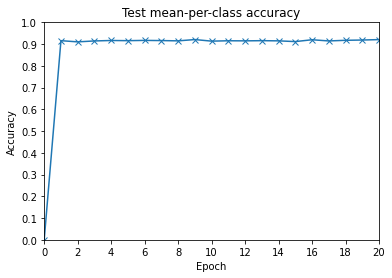

In [95]:
def plot_accuracies(Acc):
    #accuracies = [x['test_acc'] for x in history]
    plt.ylim(0,1)
    plt.xlim(0,20)
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xticks(np.arange(0,21,2))
    plt.plot(Acc, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test mean-per-class accuracy');

plot_accuracies(testAcc)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)